In [ ]:
import rasterio
import numpy as np
from datetime import datetime


def calc_fm(image):
    return 1.5 * image  # Applying flood mapping calculation

def load_tiff(filename):
    with rasterio.open(filename) as src:
        return src.read(1), src.profile

def save_tiff(output_filename, data, profile):
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open(output_filename, 'w', **profile) as dst:
        dst.write(data.astype(rasterio.float32), 1)

def evaluate_flood(before_vv, after_vv):
    before_fm = calc_fm(before_vv)
    after_fm = calc_fm(after_vv)
    
### Przenoszenie plików na serwer aplikacyjny - dla mnie

``` sftp 64.225.141.20 ```
``` lcd /run/media/franspai/a0cb24ec-506b-4775-a430-c0205aaf1a8a/Hackathon/ ```
``` cd /home/eouser ```
``` put -r hackathon-main ```
``` exit ```
    flood_mask = (before_fm - after_fm) > 0.05
    return flood_mask.astype(np.uint8)
    
    return before_fm, after_fm, after_fm

if __name__ == "__main__":
    # Load before and after images (VV polarization)
    # before_vv, profile = load_tiff("0908/2024-09-08-00_00_2024-09-08-23_59_Sentinel-1_AWS-IW-VVVH_VV_-_decibel_gamma0_-_orthorectified.tiff")
    # after_vv, _ = load_tiff("0918/2024-09-18-00_00_2024-09-18-23_59_Sentinel-1_AWS-IW-VVVH_VV_-_decibel_gamma0_-_orthorectified.tiff")
    before_vv, profile = load_tiff("otmuchow_masked/.tiff")
    after_vv, _ = load_tiff("otmuchow_maskedcz_vv_after.tiff")
    
    # Evaluate flood mapping
    
    flood_mask = evaluate_flood(before_vv, after_vv)
    save_tiff("otmuchow_masked/.tiff", flood_mask, profile)

    
    
    print("Flood mapping process completed.")


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tifffile

def display_tiff_image(file_path):
    """Displays a TIFF image or multi-page TIFF."""
    
    with tifffile.TiffFile(file_path) as tif:
        num_pages = len(tif.pages)
        print(f"Number of pages in TIFF: {num_pages}")
        
        fig, ax = plt.subplots()
        index = 0
        img = tif.pages[index].asarray()
        im_obj = ax.imshow(img, cmap='gray')
        ax.set_title(f'Page {index + 1} of {num_pages}')
        
        def update_image(event):
            nonlocal index
            if event.key == 'right':
                index = (index + 1) % num_pages
            elif event.key == 'left':
                index = (index - 1) % num_pages
            img = tif.pages[index].asarray()
            im_obj.set_data(img)
            ax.set_title(f'Page {index + 1} of {num_pages}')
            plt.draw()
        
        fig.canvas.mpl_connect('key_press_event', update_image)
        plt.show()
# Example usage
# file_path = "duplicate_during_flood.tiff"  # Change this to your TIFF file path
# display_tiff_image(file_path)

Number of pages in TIFF: 1


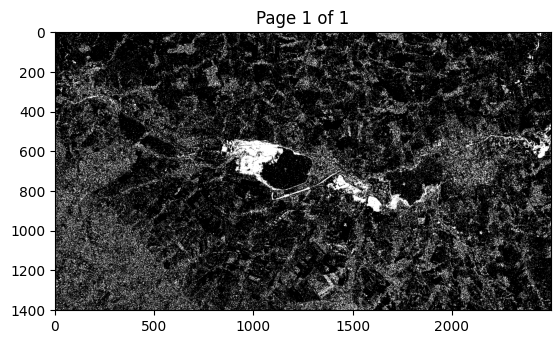

In [38]:
file_path = "o/output_masks/flood_mask_2024-09-18.tiff"  # Change this to your TIFF file path
display_tiff_image(file_path)

Number of pages in TIFF: 1


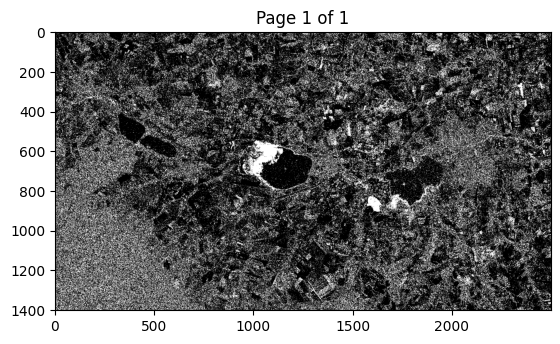

In [40]:
file_path="o/output_masks/flood_mask_2024-09-23.tiff"
display_tiff_image(file_path)

In [27]:
import rasterio

file_path = "0908/2024-09-08-00_00_2024-09-08-23_59_Sentinel-1_AWS-IW-VVVH_VH_-_decibel_gamma0_-_orthorectified.tiff"
file_path="flood_mask_nyskie.tiff"
# Open the GeoTIFF file
with rasterio.open(file_path) as dataset:
    # Print metadata
    print("Metadata:", dataset.meta)
    print("CRS:", dataset.crs)  # Coordinate Reference System
    print("Bounds:", dataset.bounds)  # Geospatial extent
    print("Transform:", dataset.transform)  # Affine transformation matrix
    print("Width:", dataset.width, "Height:", dataset.height)
    print("Bands:", dataset.count)

    # List all tags (additional metadata)
    print("\nTags:", dataset.tags())

    # Read band statistics
    for i in range(1, dataset.count + 1):  # Bands are 1-indexed
        print(f"Band {i} min: {dataset.read(i).min()}, max: {dataset.read(i).max()}")


Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1512, 'height': 2500, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0007695701058201053, 0.0, 16.90792,
       0.0, -0.0004883640000000014, 51.19415)}
CRS: EPSG:4326
Bounds: BoundingBox(left=16.90792, bottom=49.97324, right=18.07151, top=51.19415)
Transform: | 0.00, 0.00, 16.91|
| 0.00,-0.00, 51.19|
| 0.00, 0.00, 1.00|
Width: 1512 Height: 2500
Bands: 1

Tags: {'AREA_OR_POINT': 'Area'}
Band 1 min: 0.0, max: 1.0


In [35]:
import numpy as np
import rasterio

def count_black_white_pixels(file_path):
    with rasterio.open(file_path) as dataset:
        img = dataset.read(1).astype(np.float32)  # Convert to float

        # Ensure correct thresholds for 0-1 images
        black_threshold = np.min(img)  # Likely 0.0
        white_threshold = np.max(img)  # Likely 1.0

        total_pixels = img.size

        black_pixels = np.sum(img <= black_threshold)
        white_pixels = np.sum(img >= white_threshold)

        black_percentage = (black_pixels / total_pixels) * 100
        white_percentage = (white_pixels / total_pixels) * 100

        print(f"Total Pixels: {total_pixels}")
        print(f"Black Pixels (≤{black_threshold}): {black_pixels} ({black_percentage:.2f}%)")
        print(f"White Pixels (≥{white_threshold}): {white_pixels} ({white_percentage:.2f}%)")

# Run on your image
count_black_white_pixels("flood_mask_nyskie.tiff")


Total Pixels: 3780000
Black Pixels (≤0.0): 3272163 (86.57%)
White Pixels (≥1.0): 507837 (13.43%)
